<a href="https://colab.research.google.com/github/meriemdouider1/data_mining_project/blob/main/code%20final%20data%20mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [ ]:
import numpy as np 
import numpy as np # linear algebra
import pandas as pd
import pandas_profiling
import os
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
import operator
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
import numpy as np
import time 
from itertools import cycle

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score, auc


# classifiers

from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

#Reading data

In [ ]:
Questionnaire = '/content/Questionnaire.xlsx'
d_Questionnaire= pd.read_excel(Questionnaire,
sheet_name=0,
header=0,
index_col=False,
keep_default_na=True
)

In [ ]:
Démographie  = '/content/Demographie.xlsx'
d_Démographie= pd.read_excel(Démographie,
sheet_name=0,
header=0,
index_col=False,
keep_default_na=True
)

In [ ]:
examination = '/content/examination.xlsx'
d_examination= pd.read_excel(examination,
sheet_name=0,
header=0,
index_col=False,
keep_default_na=True
)

In [ ]:
lab  = '/content/labf.xlsx'
d_lab= pd.read_excel(lab,
sheet_name=0,
header=0,
index_col=False,
keep_default_na=True
)

#Dividing categorical and numerical

In [ ]:
def split_columns(df):
    col = [c for c in df.columns if c not in ['SEQN']]
    numclasses=[]
    for c in col:
        numclasses.append(len(df[c].unique()))
    threshold=10
    np.array(numclasses).size
    categorical_variables = list(np.array(col)[np.array(numclasses) < threshold])
    numerical_variables = set(df.columns)^set(categorical_variables)
    return categorical_variables, numerical_variables

In [ ]:
#questionaire data
ques_cat, ques_cont = split_columns(d_Questionnaire)
ques_obj = d_Questionnaire[list(ques_cont)].select_dtypes(include=['object']).columns
ques_cont = set(ques_cont)^set(ques_obj)



note that the questionnaire contains only categorical variables

In [ ]:
ques_cat

['DIQ010', 'DIQ160', 'DIQ170', 'DIQ172', 'DIQ180', 'DIQ050']

In [ ]:
ques_obj

Index([], dtype='object')

In [ ]:
ques_cont

{'SEQN'}

In [ ]:
#demographic data
demo_cat, demo_cont = split_columns(d_Démographie)
demo_obj = d_Démographie[list(demo_cont)].select_dtypes(include=['object']).columns
demo_cont = set(demo_cont)^set(demo_obj)
#examination data
exam_cat, exam_cont = split_columns(d_examination)
exam_obj = d_examination[list(exam_cont)].select_dtypes(include=['object']).columns
exam_cont = set(exam_cont)^set(exam_obj)
#laboratory data
labs_cat, labs_cont = split_columns(d_lab)
labs_obj = d_lab[list(labs_cont)].select_dtypes(include=['object']).columns
labs_cont = set(labs_cont)^set(labs_obj)

In [ ]:
#assert check whether we have covered all the features
assert len(ques_cat) + len(ques_cont) +len(ques_obj)  == len(d_Questionnaire.columns)
assert len(demo_cat) + len(demo_cont) +len(demo_obj) == len(d_Démographie.columns)
assert len(exam_cat) + len(exam_cont) +len(exam_obj) == len(d_examination.columns)
assert len(labs_cat) + len(labs_cont) +len(labs_obj) == len(d_lab.columns)

#Combining and Merging dataframes into single data

The concat() function (in the main pandas namespace) does all of the heavy lifting of performing concatenation operations along an axis while performing optional set logic (union or intersection) of the indexes (if any) on the other axes. 
When gluing together multiple DataFrames, we  have a choice of how to handle the other axes (other than the one being concatenated).
- we Take the intersection, join='inner' for our combination of data .


In [ ]:
#nhanes data 
d_examination.drop(['SEQN'], axis = 1, inplace=True)
d_lab.drop(['SEQN'], axis = 1, inplace=True)
d_Questionnaire.drop(['SEQN'], axis = 1, inplace=True)

#joining all dataframes into single data "df"

df = pd.concat([d_Démographie, d_examination], axis=1, join='inner')
df = pd.concat([df, d_lab], axis=1, join='inner')
df = pd.concat([df, d_Questionnaire], axis=1, join='inner')

In [ ]:
df.head()

,SEQN,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,DMDEDUC2,DMDMARTL,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,BMDSTATS,BMXWT,BMXHT,...,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXNRBC,LBXBCR,LBDBCRSI,LBDBCRLC,LBXBCO,LBDBCOSI,LBDBCOLC,LBDSF5LC,LBXSF6SI,LBDSF6LC,LBXGH,WTSAF2YR,LBXGLU,LBDGLUSI,LBDHDD,LBDHDDSI,LBXHA,LBXHBC,LBXHBS,DIQ010,DIQ160,DIQ170,DIQ172,DIQ180,DIQ050
0,93703,2,2,2,5,6,2,1,1,4,1,1,1,2,1,2,2,1,2,2,5,5,3,0,0,1,2,3,1,3,9246.491865,8539.731348,2,145,15,15,5.00,1,13.7,88.6,...,1.0,3.4,0.6,4.2,0.2,0.1,5.48,11.9,36.7,67.0,21.7,32.4,15.6,309,7.9,0.0,0.29,5.58,1,0.20,3.39,0,1,1.160,0,6.2,0.000000,97,5.38,60,1.55,1,1,1,2,2,2,2,2,2
1,93704,2,1,2,3,3,1,1,1,4,1,1,1,2,1,2,2,1,2,2,4,4,2,0,0,1,2,3,1,2,37338.768343,42566.614750,1,143,15,15,5.00,1,13.9,94.2,...,0.8,1.5,0.6,3.7,0.3,0.0,5.24,16.3,47.0,89.7,31.1,34.7,12.2,233,6.6,0.0,0.29,5.58,1,0.14,2.38,0,1,0.831,0,5.2,0.000000,97,5.38,47,1.22,2,2,2,2,2,2,2,2,2
2,93705,2,2,66,4,4,2,1,1,2,3,1,2,2,1,2,2,1,2,2,1,1,0,0,1,2,4,1,2,2,8614.571172,8338.419786,2,145,3,3,0.82,1,79.5,158.3,...,0.5,4.2,0.7,6.1,0.2,0.1,5.02,14.5,42.1,83.9,28.9,34.4,13.6,348,8.5,0.2,0.29,5.58,1,0.14,2.38,0,1,3.620,0,5.6,0.000000,97,5.38,68,1.76,2,2,2,2,2,2,2,1,2
3,93706,2,1,18,5,6,2,1,1,4,1,1,2,2,1,2,2,1,2,2,5,5,0,0,1,1,4,3,1,2,8548.632619,8723.439814,2,134,15,15,5.00,1,66.3,175.7,...,0.7,1.9,0.4,3.6,0.1,0.0,4.59,13.2,39.9,86.8,28.8,33.1,13.4,226,9.1,0.2,0.29,5.58,1,0.16,2.72,0,0,1.220,0,6.2,25653.677102,122,6.77,88,2.28,1,1,1,2,2,2,2,2,2
4,93707,2,1,13,5,7,2,1,1,4,1,1,1,2,1,2,2,1,2,2,7,7,0,3,0,1,3,2,1,3,6769.344567,7064.609730,1,138,10,10,1.88,1,45.4,158.4,...,0.6,1.9,0.5,4.8,0.1,0.0,5.13,15.4,45.5,88.8,30.0,33.8,15.7,228,9.0,0.0,0.70,13.46,0,0.34,5.77,0,1,1.940,0,6.3,0.000000,97,5.38,65,1.68,1,2,2,2,2,2,2,2,2


our data contains 7936 observations and 370 features

In [ ]:
df.shape

(7936, 370)

pandas.DataFrame.describe : Generate descriptive statistics

Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution.

In [ ]:
df.describe()

,SEQN,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,DMDEDUC2,DMDMARTL,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,BMDSTATS,BMXWT,BMXHT,...,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXNRBC,LBXBCR,LBDBCRSI,LBDBCRLC,LBXBCO,LBDBCOSI,LBDBCOLC,LBDSF5LC,LBXSF6SI,LBDSF6LC,LBXGH,WTSAF2YR,LBXGLU,LBDGLUSI,LBDHDD,LBDHDDSI,LBXHA,LBXHBC,LBXHBS,DIQ010,DIQ160,DIQ170,DIQ172,DIQ180,DIQ050
count,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,...,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.00000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.0,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000
mean,97670.500000,1.942414,1.511341,34.363029,3.235761,3.500378,1.543221,1.243826,1.117692,3.714214,2.021421,1.102949,1.657132,1.967112,1.091230,1.998236,1.972656,1.051537,1.994330,1.983619,3.710559,3.589214,0.494960,0.877772,0.489541,1.498614,2.862273,2.047001,1.463458,2.057208,34658.037726,34695.011004,1.517641,140.990927,12.567540,12.326865,2.719984,1.134955,64.789491,156.791898,...,0.754687,2.383606,0.575290,4.033556,0.204360,0.045917,4.742344,13.737273,40.903919,86.916003,29.231578,33.578427,13.735522,255.413306,8.091520,0.08503,0.317840,6.115190,0.946069,0.173364,2.944803,0.003780,0.937122,1.462138,0.0,5.681502,34331.708539,102.392641,5.680988,52.578503,1.359638,1.338080,1.948841,1.732863,1.923891,1.939012,1.908518,1.879032,1.844380,1.972530
std,2291.070201,0.232973,0.499903,25.503013,1.281829,1.705324,0.498160,1.679004,0.466398,0.987753,2.638199,0.303911,0.474698,0.178355,0.287954,0.041967,0.163093,0.221105,0.075093,0.126944,1.711820,1.755174,0.801998,1.061169,0.752156,0.500030,0.807843,0.637563,0.718063,0.497762,41429.214937,43485.753638,0.499720,4.199099,16.781947,16.758066,1.737661,0.502854,32.681992,21.463467,...,0.316667,4.174485,0.202014,1.654518,0.180871,0.051771,0.462687,1.445707,3.967844,6.138082,2.395057,0.892629,1.216110,65.320742,0.869265,0.07614,0.213558,4.106382,0.225897,0.324093,5.499527,0.061371,0.242759,1.357807,0.0,0.919355,80520.565172,22.596598,1.255185,13.723671,0.354919,0.473352,0.220908,0.442492,0.373007,0.326614,0.450664,0.730458,1.136927,0.183782
min,93703.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2571.068712,0.000000,1.000000,134.000000,1.000000,1.000000,0.000000,1.000000,3.200000,78.300000,...,0.100000,0.400000,0.100000,0.400000,0.000000,0.000000,2.320000,6.400000,23.000000,35.400000,12.400000,25.200000,11.300000,8.000000,5.400000,0.00000,0.290000,5.580000,0.000000,0.040000,0.680000,0.000000,0.000000,0.113000,0.0,3.800000,0.000000,47.000000,2.610000,10.000000,0.260000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,95686.750000,2.000000,1.000000,11.000000,3.000000,3.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.

Removing na's if in rows and columns from the merged dataframe :

In [ ]:
lst = df.columns[df.isna().all()].tolist()
df.dropna(axis=1, how='all',inplace=True)
df.dropna(axis=0, how='all',inplace=True)
df.shape

(7936, 370)

# Output label assignment "Diabète" 


Fasting blood sugar levels give vital clues about how a person’s body is managing blood sugar. Blood sugar tends to peak about an hour after eating and declines after that.

High fasting blood sugar levels point to insulin resistance or diabetes, while abnormally low fasting blood sugar could be due to diabetes medications.
.
A fasting blood sugar level of 99 mg/dL or lower is normal, 100 to 125 mg/dL indicates you have prediabetes, and 126 mg/dL or higher indicates you have diabetes.
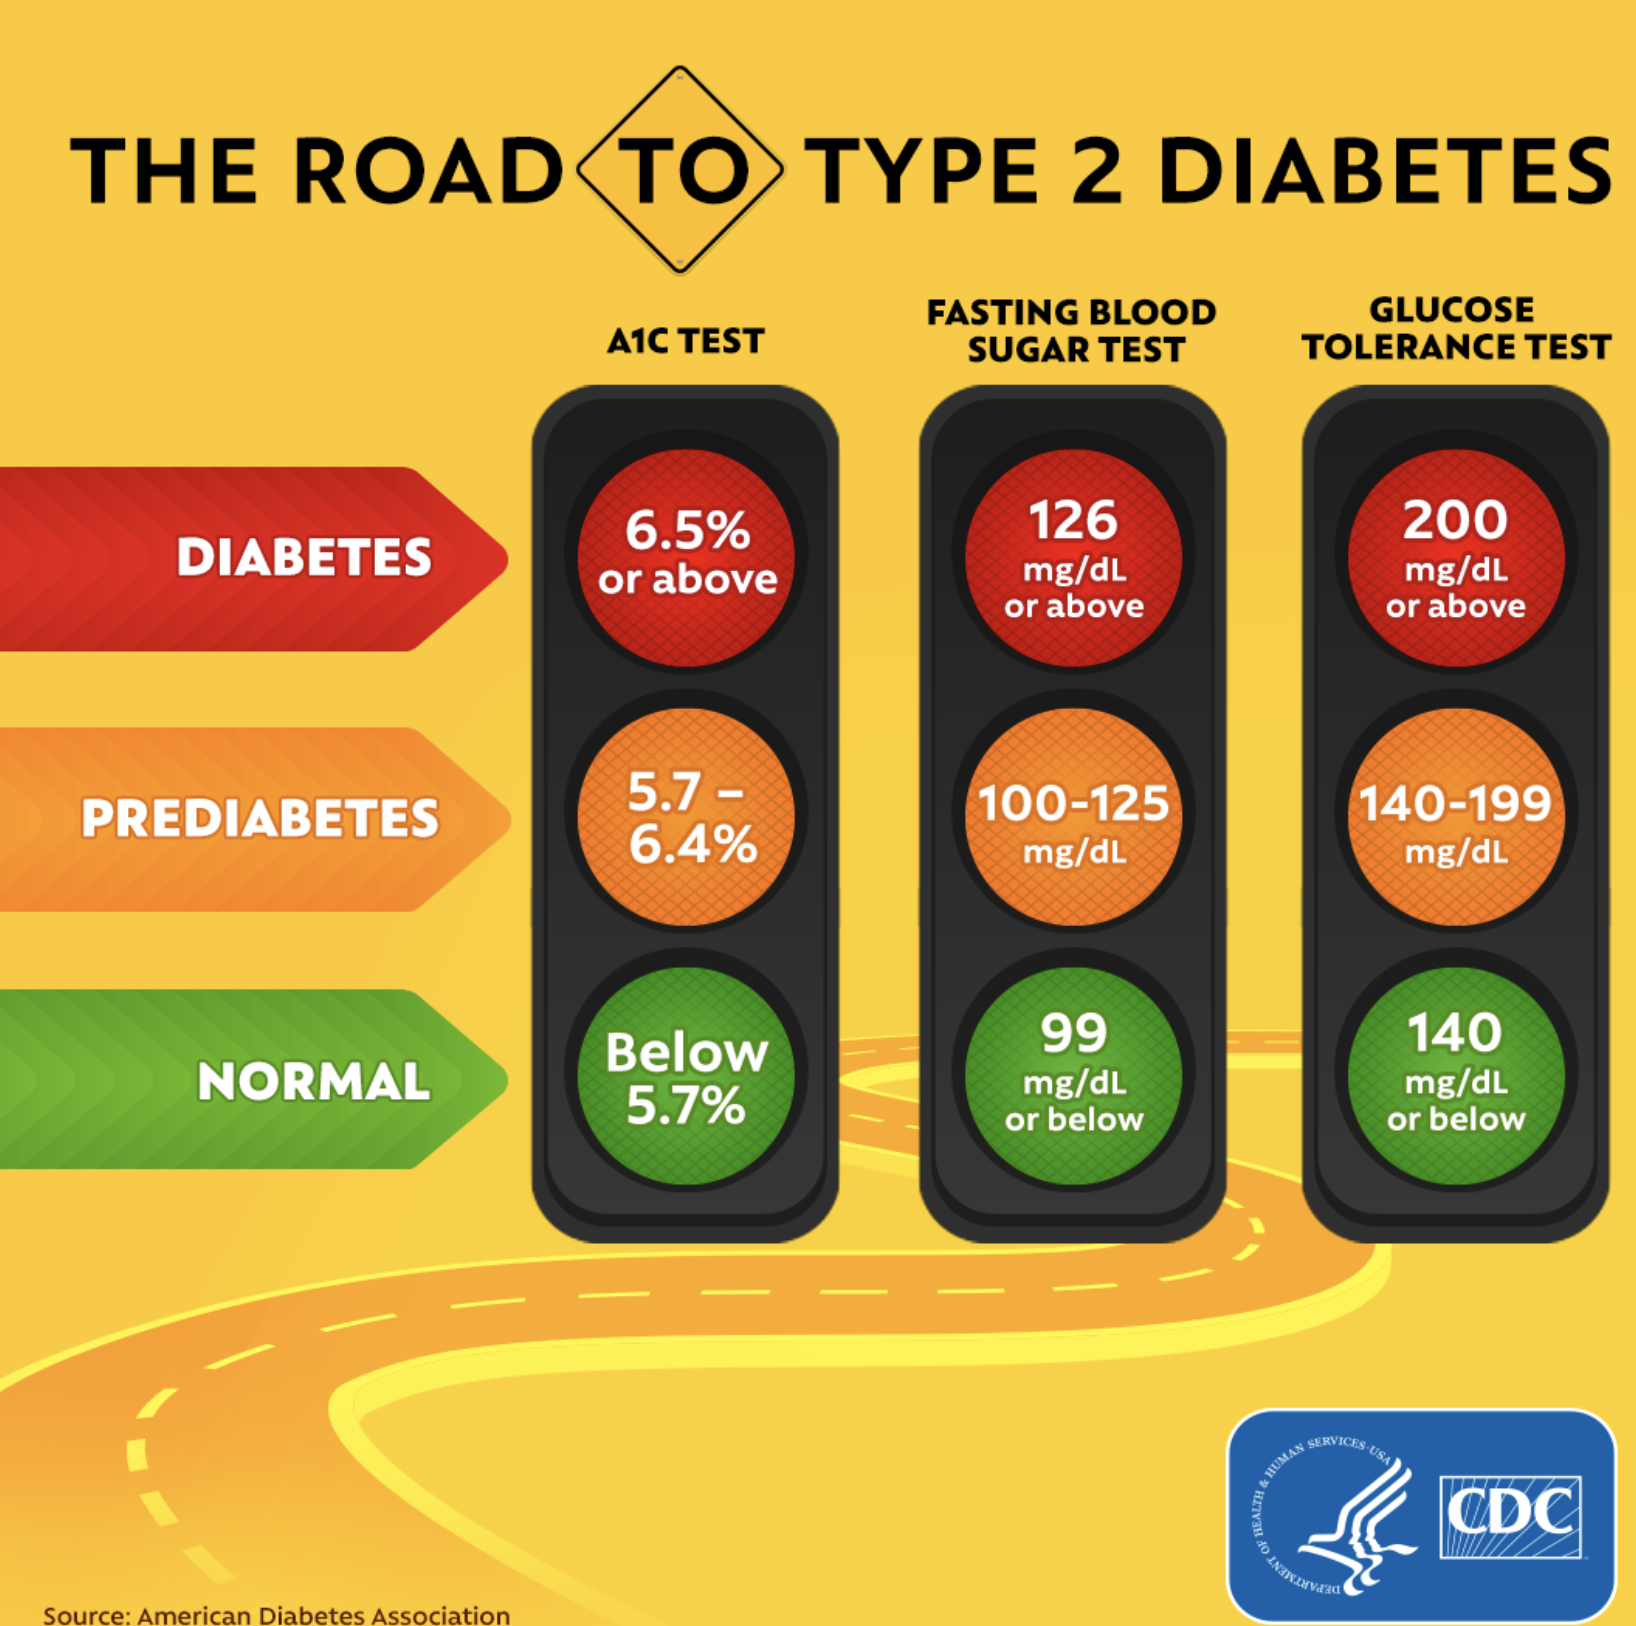
[texte du lien](https://https://www.cdc.gov/diabetes/basics/getting-tested.html)

In [21]:
df.loc[(df['LBXGLU'] < 100) , 'Diabetes'] = 0
df.loc[((df['LBXGLU'] >= 100) & (df['LBXGH'] <= 125)) , 'Diabetes'] = 1
df.loc[(df['LBXGLU'] > 125) , 'Diabetes'] = 2

Apart from the  attribute « LBXGLU
 » , there are other variables in the dataset which tells whether the person was informed whether he had diabetes before, or prediabetes before **(DIQ010)**. Using these, we are assigning output labels as 0-no diabetes, 1-prediabetes, 2-diabetic

In [22]:
df.loc[((df.Diabetes.isna()) & (df.DIQ010 == 1)), 'Diabetes'] = 2
df.loc[((df.Diabetes.isna()) & (df.DIQ010 == 3)), 'Diabetes'] = 1
df.loc[((df.Diabetes.isna()) & (df.DIQ010 == 2)), 'Diabetes'] = 0

In [23]:
##removing the rows with nan diabetes values 
df = df[np.isfinite(df['Diabetes'])]

a column is added to our database corresponding to the variable diabetes

In [24]:
df.shape

(7936, 371)

In [25]:
df.Diabetes.value_counts()

0.0    6180
1.0    1346
2.0     410
Name: Diabetes, dtype: int64



*   0-no diabetes 
*   1-prediabetes
*   2-diabetic







Text(0, 0.5, 'Number of counts')

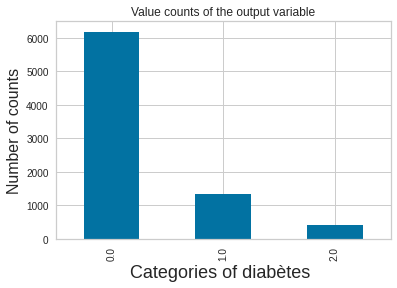

In [27]:
pd.value_counts(df['Diabetes']).plot(kind="bar", title='Value counts of the output variable')
plt.xlabel('Categories of diabète ', fontsize=18)
plt.ylabel('Number of counts', fontsize=16)

#Dimensionality reduction

Dimensional reduction, or variable reduction technique, simply refers to the process of reducing the number or dimensions of features in a data set.

In [28]:
cat_vars = ques_cat+demo_cat+exam_cat+labs_cat
cat_vars = [x for x in cat_vars if x not in lst]
num_vars = list(ques_cont)+list(demo_cont)+list(exam_cont)+list(labs_cont)
num_vars = [x for x in num_vars if x not in lst]
obj_vars = list(set(df.columns)^set(cat_vars)^set(num_vars))

**Dimensionality Reduction and variance check using PCA**

In [29]:
X = df.drop(labels = ['Diabetes','LBXGLU','DIQ010','DIQ160'], axis=1).values
y = df['Diabetes'].values
X = StandardScaler().fit_transform(X)

In [30]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['Diabetes']]], axis = 1)

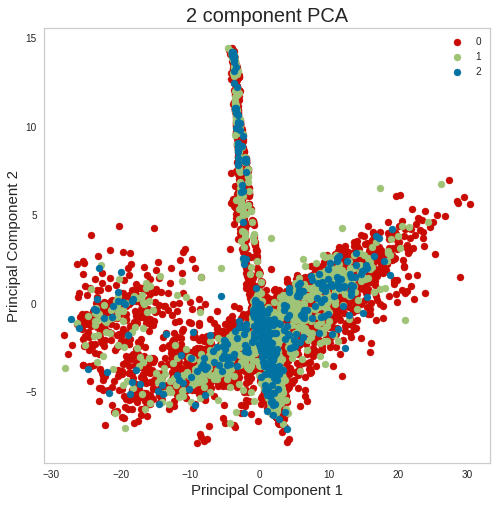

In [31]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Diabetes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [32]:
pca.explained_variance_ratio_

array([0.14990355, 0.06226945])

According to the variance ratio obtained from the last code, for a Number of principal components = 2 (**pca.explained_variance_ratio_**), it is barely 21%, which is not really useful.


now adding the 3 components

In [33]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df[['Diabetes']]], axis = 1)

In [34]:
pca.explained_variance_ratio_

array([0.14990355, 0.06226945, 0.04463875])

obtain all the components and plot the explained variance cumulate against the number of components (components : composantes principale)

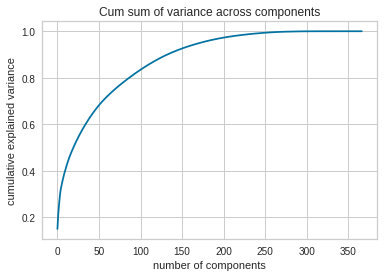

In [35]:
pca =  PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cum sum of variance across components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

After plotting the cumulative sum of the variance over the number of components, to get 90% variance, we should use at least 150 features, which is very close to our actual size. We are not doing dimensionality reduction now.

**Dimensionality Reduction using various ML models**

- **Linear regression with lasso**

In [36]:
reg = LassoCV(cv=5, random_state=0).fit(X, y)
reg.score(X, y)


0.5965747545748417

In [37]:
(reg.coef_)

array([ 9.90411020e-04,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  1.84596829e-04, -1.52917390e-03,
        1.75697110e-03, -3.21338856e-06, -2.82760029e-03, -1.85547124e-03,
       -1.75554551e-03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -4.79959908e-03, -2.97653480e-04, -9.42392351e-05,
       -0.00000000e+00, -7.55854043e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -4.02533027e-04, -0.00000000e+00, -5.78356251e-04,
       -5.85993672e-03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  5.77337564e-03,  0.00000000e+00,
       -1.61328455e-03, -2.76147308e-03, -0.00000000e+00, -0.00000000e+00,
       -3.18649379e-03, -2.12445384e-03,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -5.68753858e-04, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -1.10139329e-03, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

In [38]:
coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)

In [39]:
coefficients.columns = ['column','coeff']


Picking up the top 20 features

In [40]:
lasso_75 = coefficients.sort_values('coeff',ascending = False).head(75)
features_lasso = list(lasso_75.column)
features_lasso[:21]

['LBXGLU',
 'WTSAF2YR',
 'LBXSNASI',
 'LBXSGB',
 'LBXSUA',
 'LBXHCT',
 'LBXSBU',
 'LBXSATSI',
 'LBXRDW',
 'LBXEOPCT',
 'OHX23CTC',
 'LBXSTB',
 'LBXSAPSI',
 'LBXMCVSI',
 'LBXMPSI',
 'OHX29SE',
 'LBXBAPCT',
 'OHX19TC',
 'LUXCPIQR',
 'URXUCR',
 'LBXSIR']

- **Random forests for predicting top 20 features**

Random forests are good estimators for the output feature importance. We are selecting the top 20.

In [41]:
param_grid = dict()
clf = RandomForestClassifier(n_estimators=500, random_state=0)
grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=3,scoring='accuracy').fit(X, list(y))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.994, total=  13.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


[CV] .................................... , score=0.989, total=  13.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.4s remaining:    0.0s


[CV] .................................... , score=0.994, total=  14.0s
[CV]  ................................................................
[CV] .................................... , score=0.991, total=  13.9s
[CV]  ................................................................
[CV] .................................... , score=0.991, total=  13.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [42]:
clf = grid_search.best_estimator_
clf.fit(X,list(y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [43]:
d = {}
for feature in zip(df.columns,clf.feature_importances_):
    d[feature[0]]=feature[1]
    

sorted_d = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
dic = sorted_d[:75]
lst_rf = list(zip(*dic))

In [45]:
features_rf = lst_rf[0]
features_rf[:20]

('LBXGLU',
 'WTSAF2YR',
 'LBXSGL',
 'LBDSGLSI',
 'LBXGH',
 'LBXSGTSI',
 'LBXHCT',
 'LBDSUASI',
 'LBXSTR',
 'LBXSUA',
 'LBXSOSSI',
 'LBXSPH',
 'LBDSPHSI',
 'LBXSATSI',
 'LBDSTRSI',
 'LBXRBCSI',
 'LBXSF6SI',
 'LBXSCK',
 'LBXHGB',
 'LBXWBCSI')

 **Using complex wrapper methods- RandomForests with Boruta**

In [46]:
pip install Boruta

     |████████████████████████████████| 61kB 3.2MB/s 


In [47]:
from boruta import BorutaPy

In [48]:
import imp
import sys

In [49]:
rfc = RandomForestClassifier(n_estimators=15, n_jobs=4, class_weight='balanced', max_depth=6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
df2 = df.drop(labels = ['Diabetes','LBXGLU','DIQ010','SEQN','DIQ160'],axis=1)

x=df2.values
boruta_selector.fit(x,list(df['Diabetes'].values))
print (boruta_selector.n_features_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	9 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	10 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	11 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	12 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	13 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	14 / 100
Confirmed: 	62
Tentative: 	7
Rejected: 	297
Iteration: 	15 / 100
Confirmed: 	62
Tentative: 	6
Rejected: 	298
Iteration: 	16 / 100
Confirmed: 	62
Tenta

In [50]:
(boruta_selector.ranking_).shape
print ('\n Top %d features:' % boruta_selector.n_features_)
df_boruta = df2.head(boruta_selector.n_features_)
features_boruta = df_boruta.columns


 Top 62 features:


In [51]:
boruta_selector.ranking_

array([281, 237,  21, 154, 172, 223, 234, 219, 178, 163, 271, 228, 214,
       259, 294, 266, 273, 296, 291, 137, 111, 187, 175, 159, 223, 184,
       192, 188, 202,   2,   8, 179,  80,  64,  95,  21, 249,  26,   9,
        19,  12,  10,  13,  11,  25, 297, 196,  26, 287, 297, 143,  37,
        37, 302,  16,  29, 295,  41,  36, 291, 258, 287, 120, 147, 146,
       119,  96, 127, 126,  85, 118, 270, 244, 123, 150,  80, 108, 130,
       145, 139, 108, 132, 132,  99, 122, 206, 281,  46,  35,  34, 285,
        50,  60,  87,  86,  89, 227,  69,  42,  70, 240,  75,  40, 104,
        67,  32, 216,  54,  77,  55, 234,  90, 120, 105, 128,  33, 250,
       100,  58, 103, 228,  93,  90,  84, 101,  20, 174, 115,  48, 117,
       181,  57, 144, 125,  73,  39,  23,  82,  93,  53,  43,  74,  71,
        75,  58,  49,  97,  71,  29, 107,  44, 194,  62,  66, 111, 194,
        62, 101, 134, 110,  24,  68,  88, 129,  92, 141, 139, 123,  28,
        83,  51,  77,  97, 134, 115, 115,  61, 251,   6, 231, 13

**Lightbgm**

Plot feature importances…


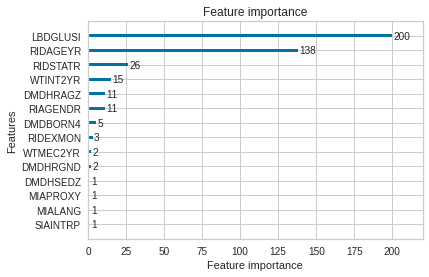

In [52]:
df_new = df.drop(labels = ['Diabetes','LBXGLU','DIQ010','SEQN','DIQ160'], axis=1)
ob_vars = df_new.select_dtypes(include=['object'])
for i in ob_vars:
    df_new[i] = df_new[i].astype(str).astype(float)
lbg_cat_vars = list(set(cat_vars)^set(['LBXGLU','DIQ160','DIQ010']))
lst = ['LBXGLU','DIQ160','DIQ010']
lbg_cat_vars.remove('LBXGLU')
d_train = lgb.Dataset(df_new, label=df['Diabetes'])
param = {'max_depth': 5, 'learning_rate' : 0.1, 'num_leaves': 900, 'n_estimators': 100}
model2 = lgb.train(params=param,train_set=d_train, categorical_feature=lbg_cat_vars)
print('Plot feature importances…')
ax = lgb.plot_importance(model2, max_num_features=20)
plt.show()

In [53]:
lst = []
for f in range(len(model2.feature_importance())):
    val=list(model2.feature_importance())[f]
    if val!=0:
        lst.append(list(model2.feature_name())[list(model2.feature_importance()).index(val)])

In [54]:
features_lgb = list(set(lst))

In [55]:
features_lgb

['RIDSTATR',
 'DMDBORN4',
 'DMDHRGND',
 'RIAGENDR',
 'WTINT2YR',
 'SIAINTRP',
 'RIDAGEYR',
 'RIDEXMON',
 'LBDGLUSI']

# **Final Selecting features from the above models**





We have analyzed the above results, and we test on several combinations we found that the intersection of the main characteristics of the data by  lasso the one that gives a good result in the part of the classification


In [56]:
features = [features_lasso, features_rf, features_boruta, features_lgb]

In [57]:
features_lasso

['LBXGLU',
 'WTSAF2YR',
 'LBXSNASI',
 'LBXSGB',
 'LBXSUA',
 'LBXHCT',
 'LBXSBU',
 'LBXSATSI',
 'LBXRDW',
 'LBXEOPCT',
 'OHX23CTC',
 'LBXSTB',
 'LBXSAPSI',
 'LBXMCVSI',
 'LBXMPSI',
 'OHX29SE',
 'LBXBAPCT',
 'OHX19TC',
 'LUXCPIQR',
 'URXUCR',
 'LBXSIR',
 'INDHHIN2',
 'OHX02CTC',
 'DXXWDBMC',
 'DXDSTLE',
 'LBXMOPCT',
 'OHX31SE',
 'OHX12SE',
 'LUXSIQR',
 'OHX25CTC',
 'BPXSY3',
 'OHXRRESO',
 'DXXPEBMD',
 'LBXSCK',
 'LBXHBC',
 'DMDCITZN',
 'LBXSC3SI',
 'OHX31TC',
 'LBDSUASI',
 'SEQN',
 'DXXL3A',
 'LBDSBUSI',
 'OHX10TC',
 'OHX26TC',
 'DIQ010',
 'LUANMVGP',
 'RIDEXMON',
 'Unnamed: 0',
 'OHX20TC',
 'LBDSIRSI',
 'URXCRS',
 'LBDSGBSI',
 'OHX07CTC',
 'OHX30TC',
 'OHX22CTC',
 'OHX21CTC',
 'OHX19CTC',
 'OHX18CTC',
 'OHX27TC',
 'OHX28TC',
 'OHX29TC',
 'OHX13CTC',
 'OHX14CTC',
 'OHX06CTC',
 'OHX12CTC',
 'OHX11CTC',
 'DXDTOBMD',
 'OHX10CTC',
 'OHX03CTC',
 'OHX08CTC',
 'OHX25TC',
 'OHX05CTC',
 'OHX04CTC',
 'LUXSIQRM',
 'OHX24TC']

In [58]:
list(set(features_lasso))
selected_features= ['LBXSBU',
 'OHX10TC',
 'BPXSY3',
 'INDHHIN2',
 'OHX29SE',
 'OHX19TC',
 'LBDSIRSI',
 'OHX25TC',
 'LBXSNASI',
 'OHX07CTC',
 'OHX19CTC',
 'LBXSATSI',
 'DIQ010',
 'OHX13CTC',
 'OHX04CTC',
 'OHX24TC',
 'OHX25CTC',
 'Unnamed: 0',
 'OHX03CTC',
 'OHX11CTC',
 'OHX26TC',
 'OHX23CTC',
 'LBXSTB',
 'OHX02CTC',
 'DXXWDBMC',
 'LBXSC3SI',
 'URXCRS',
 'OHX21CTC',
 'LBXSCK',
 'OHX29TC',
 'OHX12CTC',
 'LBXSUA',
 'OHX27TC',
 'DMDCITZN',
 'WTSAF2YR',
 'DXDSTLE',
 'OHXRRESO',
 'OHX18CTC',
 'OHX10CTC',
 'OHX05CTC',
 'LBXSAPSI',
 'LBXSIR',
 'OHX22CTC',
 'DXDTOBMD',
 'URXUCR',
 'LBXMOPCT',
 'LUXSIQRM',
 'DXXPEBMD',
 'LBXBAPCT',
 'DXXL3A',
 'LBDSGBSI',
 'OHX30TC',
 'OHX31TC',
 'OHX06CTC',
 'LUANMVGP',
 'LBDSUASI',
 'LBXMCVSI',
 'OHX20TC',
 'OHX28TC',
 'OHX08CTC',
 'LBXMPSI',
 'LBXEOPCT',
 'LBDSBUSI',
 'OHX31SE',
 'OHX12SE',
 'LBXSGB',
 'LBXRDW',
 'LBXHCT',
 'LBXGLU',
 'LUXSIQR',
 'LUXCPIQR',
 'SEQN',
 'RIDEXMON',
 'LBXHBC',
 'OHX14CTC']

In [59]:
selected_features.append('Diabetes')
selected_features.append('SEQN')
df_model = df[selected_features]

In [60]:
df_model

,LBXSBU,OHX10TC,BPXSY3,INDHHIN2,OHX29SE,OHX19TC,LBDSIRSI,OHX25TC,LBXSNASI,OHX07CTC,OHX19CTC,LBXSATSI,DIQ010,OHX13CTC,OHX04CTC,OHX24TC,OHX25CTC,Unnamed: 0,OHX03CTC,OHX11CTC,OHX26TC,OHX23CTC,LBXSTB,OHX02CTC,DXXWDBMC,LBXSC3SI,URXCRS,OHX21CTC,LBXSCK,OHX29TC,OHX12CTC,LBXSUA,OHX27TC,DMDCITZN,WTSAF2YR,DXDSTLE,OHXRRESO,OHX18CTC,OHX10CTC,OHX05CTC,LBXSAPSI,LBXSIR,OHX22CTC,DXDTOBMD,URXUCR,LBXMOPCT,LUXSIQRM,DXXPEBMD,LBXBAPCT,DXXL3A,LBDSGBSI,OHX30TC,OHX31TC,OHX06CTC,LUANMVGP,LBDSUASI,LBXMCVSI,OHX20TC,OHX28TC,OHX08CTC,LBXMPSI,LBXEOPCT,LBDSBUSI,OHX31SE,OHX12SE,LBXSGB,LBXRDW,LBXHCT,LBXGLU,LUXSIQR,LUXCPIQR,SEQN,RIDEXMON,LBXHBC,OHX14CTC,Diabetes,SEQN
0,11,1,116,15,0,4,16.8,1,141,1,10,16,2,1,1,1,1,0,9,1,1,1,0.6,8,0.61,31,2121.6,1,166,1,1,5.8,1,1,0.000000,42404.444895,2,8,1,1,74,94,1,1.052169,24.0,7.4,11.1,1.181125,1.0,12.98,29,4,4,1,10,345.0,67.0,1,1,1,7.9,2.9,3.93,9,0,2.9,15.6,36.7,97,0.3,33,93703,2,1,9,0.0,93703
1,12,1,116,15,0,4,29.2,1,144,1,10,10,2,1,1,1,1,1,9,1,1,1,0.7,8,0.61,28,6099.6,1,114,1,1,8.0,1,1,0.000000,42404.444895,2,8,1,1,79,163,1,1.052169,69.0,9.1,11.1,1.181125,0.8,12.98,27,4,4,1,10,475.8,89.7,1,1,1,6.6,4.3,4.28,9,0,2.7,12.2,47.0,97,0.3,33,93704,1,2,9,0.0,93704
2,17,2,202,3,0,4,16.1,2,137,10,7,13,2,3,3,2,9,2,1,10,2,10,0.7,1,0.64,22,18475.6,3,342,2,3,5.5,2,1,0.000000,42404.444895,2,1,10,3,238,90,10,1.052169,209.0,6.2,24.0,1.181125,0.5,14.89,28,4,2,10,10,327.1,83.9,2,2,10,8.5,1.6,6.07,9,0,2.8,13.6,42.1,97,3.0,28,93705,2,2,2,0.0,93705
3,16,2,108,15,0,2,17.2,2,144,10,2,19,2,10,10,2,9,3,2,10,2,10,0.5,7,0.61,27,4154.8,10,347,2,10,4.5,2,1,25653.677102,45579.000000,2,7,10,10,66,96,10,1.007000,47.0,6.8,18.2,1.076000,0.7,12.98,32,2,2,10,12,267.7,86.8,2,2,10,9.1,2.0,5.71,0,0,3.2,13.4,39.9,122,1.0,19,93706,2,1,8,1.0,93706
4,20,2,128,10,9,2,11.8,2,141,10,8,15,2,1,1,2,9,4,8,1,2,10,0.3,8,0.61,24,19006.0,10,63,2,1,6.2,2,1,0.000000,32505.000000,2,8,10,1,86,66,10,0.881000,215.0,6.8,20.4,0.992000,0.6,12.98,33,2,2,1,10,368.8,88.8,1,1,10,9.0,0.8,7.14,9,0,3.3,15.7,45.5,97,1.0,66,93707,2,2,8,0.0,93707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,13,2,128,6,0,2,25.1,2,143,10,2,22,2,10,3,2,9,7931,2,10,2,10,1.2,1,0.61,27,4508.4,10,67,2,3,6.4,2,1,32733.048593,42404.444895,2,1,10,10,57,140,10,1.052169,51.0,7.1,11.6,1.181125,0.6,12.98,26,2,2,10,11,380.7,87.7,2,2,10,9.1,1.3,4.64,9,0,2.6,13.3,40.6,158,0.8,53,101634,1,1,2,2.0,101634
7932,17,2,132,8,0,2,12.5,2,144,10,2,40,2,3,3,2,9,7932,2,10,2,10,0.6,7,0.61,24,20420.4,10,144,2,3,5.8,2,1,0.000000,63534.400000,2,1,10,10,115,70,10,1.173000,231.0,6.8,9.4,1.314000,0.6,12.98,35,2,2,10,10,345.0,88.8,2,2,10,8.7,3.6,6.07,9,0,3.5,13.6,44.4,97,0.6,35,101635,2,2,2,0.0,101635
7933,8,2,142,99,0,2,3.6,2,137,10,8,6,2,3,10,2,9,7933,8,10,2,10,0.2,7,0.64,21,2740.4,10,96,2,10,3.1,2,1,50637.453793,64339.400000,2,7,10,10,55,20,10,1.223000,31.0,11.8,7.5,1.289000,1.4,15.32,26,2,2,10,10,184.4,61.9,2,2,10,9.7,3.5,2.86,9,0,2.6,19.6,23.1,94,0.3,69,101636,1,2,8,0.0,101636
7934,11,2,168,1,0,4,3.6,2,138,9,1,11,2,2,2,2,3,7934,1,2,2,10,0.2,1,0.61,23,15646.8,3,204,2,2,6.3,2,1,0.000000,42404.444895,2,0,3,2,84,20,3,1.052169,177.0,7.3,11.1,1.181125,0.9,15.48,34,4,4,3,16,374.7,68.4,2,2,3,7.7,1.1,3.93,9,0,3.4,17.4,33.7,97,0.4,64,101637,1,2,1,0.0,101637


In [61]:
X = X = df_model.drop(labels = ['Diabetes'], axis=1).values
y = df['Diabetes'].values
X = StandardScaler().fit_transform(X)

# Exploratory Data Analysis on selected features

In [62]:
selected_features

['LBXSBU',
 'OHX10TC',
 'BPXSY3',
 'INDHHIN2',
 'OHX29SE',
 'OHX19TC',
 'LBDSIRSI',
 'OHX25TC',
 'LBXSNASI',
 'OHX07CTC',
 'OHX19CTC',
 'LBXSATSI',
 'DIQ010',
 'OHX13CTC',
 'OHX04CTC',
 'OHX24TC',
 'OHX25CTC',
 'Unnamed: 0',
 'OHX03CTC',
 'OHX11CTC',
 'OHX26TC',
 'OHX23CTC',
 'LBXSTB',
 'OHX02CTC',
 'DXXWDBMC',
 'LBXSC3SI',
 'URXCRS',
 'OHX21CTC',
 'LBXSCK',
 'OHX29TC',
 'OHX12CTC',
 'LBXSUA',
 'OHX27TC',
 'DMDCITZN',
 'WTSAF2YR',
 'DXDSTLE',
 'OHXRRESO',
 'OHX18CTC',
 'OHX10CTC',
 'OHX05CTC',
 'LBXSAPSI',
 'LBXSIR',
 'OHX22CTC',
 'DXDTOBMD',
 'URXUCR',
 'LBXMOPCT',
 'LUXSIQRM',
 'DXXPEBMD',
 'LBXBAPCT',
 'DXXL3A',
 'LBDSGBSI',
 'OHX30TC',
 'OHX31TC',
 'OHX06CTC',
 'LUANMVGP',
 'LBDSUASI',
 'LBXMCVSI',
 'OHX20TC',
 'OHX28TC',
 'OHX08CTC',
 'LBXMPSI',
 'LBXEOPCT',
 'LBDSBUSI',
 'OHX31SE',
 'OHX12SE',
 'LBXSGB',
 'LBXRDW',
 'LBXHCT',
 'LBXGLU',
 'LUXSIQR',
 'LUXCPIQR',
 'SEQN',
 'RIDEXMON',
 'LBXHBC',
 'OHX14CTC',
 'Diabetes',
 'SEQN']

In [63]:
categorical_features = list(set(selected_features).intersection(cat_vars))
print('categorical: ',categorical_features)
continuos_features = list(set(selected_features).intersection(num_vars))
print('continous: ',continuos_features)

categorical:  ['DIQ010', 'DMDCITZN', 'OHX27TC', 'OHX24TC', 'OHX31TC', 'OHX30TC', 'OHX26TC', 'OHX31SE', 'OHX12SE', 'LBXHBC', 'OHX10TC', 'OHX28TC', 'OHX29TC', 'OHXRRESO', 'OHX29SE', 'OHX19TC', 'OHX25TC', 'OHX20TC', 'RIDEXMON']
continous:  ['OHX25CTC', 'URXCRS', 'OHX07CTC', 'LBXMOPCT', 'LBXEOPCT', 'OHX04CTC', 'LBXHCT', 'OHX11CTC', 'OHX12CTC', 'LBXSIR', 'LBXSUA', 'OHX08CTC', 'DXXPEBMD', 'LBDSUASI', 'OHX13CTC', 'LBXSAPSI', 'URXUCR', 'OHX02CTC', 'LUANMVGP', 'OHX05CTC', 'LUXSIQRM', 'LBXSBU', 'OHX10CTC', 'LBXMPSI', 'LBXRDW', 'Unnamed: 0', 'LUXCPIQR', 'LBXSNASI', 'INDHHIN2', 'LBXMCVSI', 'DXXWDBMC', 'LBXSCK', 'LBXSGB', 'LBDSGBSI', 'LUXSIQR', 'OHX23CTC', 'OHX06CTC', 'SEQN', 'DXDTOBMD', 'LBDSBUSI', 'OHX21CTC', 'LBXSTB', 'OHX03CTC', 'WTSAF2YR', 'OHX22CTC', 'OHX18CTC', 'LBDSIRSI', 'LBXSATSI', 'LBXSC3SI', 'BPXSY3', 'OHX14CTC', 'LBXBAPCT', 'LBXGLU', 'OHX19CTC', 'DXDSTLE', 'DXXL3A']


In [64]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7936 entries, 0 to 7935
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LBXSBU      7936 non-null   int64  
 1   OHX10TC     7936 non-null   int64  
 2   BPXSY3      7936 non-null   int64  
 3   INDHHIN2    7936 non-null   int64  
 4   OHX29SE     7936 non-null   int64  
 5   OHX19TC     7936 non-null   int64  
 6   LBDSIRSI    7936 non-null   float64
 7   OHX25TC     7936 non-null   int64  
 8   LBXSNASI    7936 non-null   int64  
 9   OHX07CTC    7936 non-null   int64  
 10  OHX19CTC    7936 non-null   int64  
 11  LBXSATSI    7936 non-null   int64  
 12  DIQ010      7936 non-null   int64  
 13  OHX13CTC    7936 non-null   int64  
 14  OHX04CTC    7936 non-null   int64  
 15  OHX24TC     7936 non-null   int64  
 16  OHX25CTC    7936 non-null   int64  
 17  Unnamed: 0  7936 non-null   int64  
 18  OHX03CTC    7936 non-null   int64  
 19  OHX11CTC    7936 non-null  

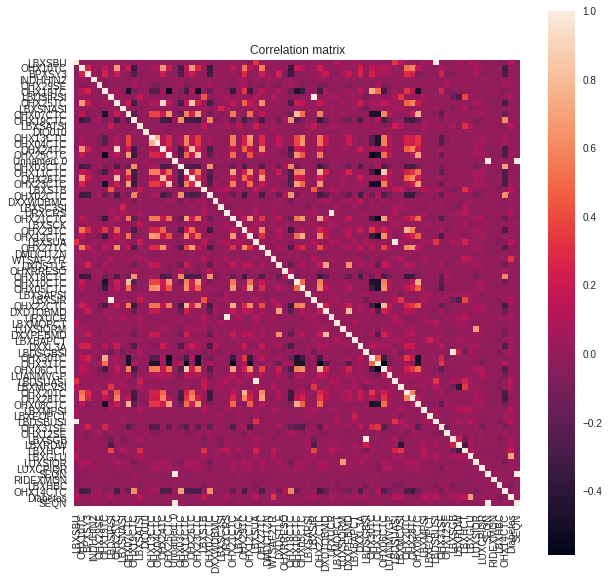

In [66]:
corr = df_model.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation matrix')
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values, square=True)

#Doing the Test Train split


The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make classification on data not used to train the model.
The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.


  - Train Dataset "74%" : Used to fit the machine learning model.
  - Test Dataset "26 %": Used to evaluate the fit machine learning model. 








In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [69]:
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)

In [70]:
len(X_train)

5952

In [71]:
len(X_test)

1984

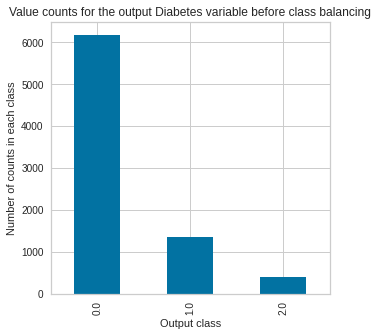

In [73]:
plt.figure(figsize=(5,5))
plt.title('Value counts for the output Diabetes variable before class balancing')
plt.xlabel('Output class')
plt.ylabel('Number of counts in each class')
pd.value_counts(df_y[0]).plot(kind="bar")

In [74]:
np.unique(y_train)

array([0., 1., 2.])

# Data Balancing

Now let's move on to the Classification part of the project. Once after selecting the features, we did some exploratory data analysis by plotting the variance between features, imputing data, and then we did a train split test for the models. After our analysis, we realized that our output function is very unbalanced, with one more data point class which is the majority class and the other two are minority. The problem with this is that the models may tend to predict the majority class very well, but they don't do so well in the minority classes. And in our case, the prediction of the diabetic and pre-diabetic minority classes is extremely important. We used a synthetic minority oversampling technique to balance our data before entering it into machine learning models. These are the class distributions before and after balancing using SMOTE. The output variable is highly unbalanced. We use balancing techniques to modify the data for better model prediction. We chose the SMOTE technique to perform our data balancing.

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [75]:
## Instantiate smote and balance training data only
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

## Compute and print percentage of high quality wine after balancing
print('Percentage of high quality counts in the balanced data:{}%'.format((y_res==1).sum()/X_res.shape[0]*100))

Percentage of high quality counts in the balanced data:33.33333333333333%


In [76]:
df_X_smote = pd.DataFrame(X_res)
df_y_smote = pd.DataFrame(y_res)

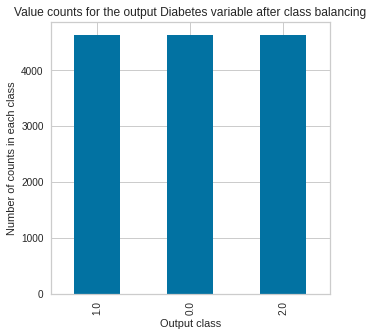

In [77]:
plt.figure(figsize=(5,5))
plt.title('Value counts for the output Diabetes variable after class balancing')
plt.xlabel('Output class')
plt.ylabel('Number of counts in each class')
pd.value_counts(df_y_smote[0]).plot(kind="bar")

# Model Training and Evaluation

After cleaning, and transforming the data into machine learning ready, we have used various classifiers to predict our outputs.

In [78]:

def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

In [79]:
# Binarize the output
y_res = label_binarize(y_res, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]

In [80]:
data_dict = {}
data_dict['X_train'] = X_res
data_dict['y_train'] = y_res
data_dict['X_test'] = X_test
data_dict['y_test'] = y_test

In [81]:
default_seed = 1

In [82]:
data_dict

{'X_test': array([[-0.42267651, -0.16952254, -0.21839262, ...,  0.23160135,
          0.73315673, -1.71262636],
        [-0.23065861, -0.16952254,  2.59866062, ...,  0.23160135,
         -1.22401044, -1.09715467],
        [-0.23065861, -0.16952254,  0.57038229, ...,  0.23160135,
         -1.55020497, -1.01421877],
        ...,
        [-0.61469442, -0.16952254, -0.10571049, ...,  0.23160135,
         -1.22401044,  0.73791127],
        [-0.23065861, -0.16952254,  0.68306442, ...,  0.23160135,
         -1.22401044, -1.58080193],
        [-0.99873023, -0.16952254,  0.79574655, ...,  0.23160135,
          0.73315673,  1.09802768]]),
 'X_train': array([[-0.23065861, -0.16952254, -0.55643901, ...,  0.23160135,
         -1.22401044,  0.8142996 ],
        [ 0.34539511, -0.16952254, -1.11984966, ...,  0.23160135,
          0.73315673, -0.92037025],
        [ 1.30548465, -0.16952254,  0.79574655, ...,  0.23160135,
         -1.22401044, -1.44373944],
        ...,
        [ 2.81342223, -1.39255063

#Fitting various models

In [87]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                           metric='f1_micro',
                          model_name = None,
                          n_splits=3,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts  
      - metric = scoring
    '''
        
    out = {} # output dictionary
    

    #  Load the data :
    
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']  
  

    # Fit the model :

    # Learn to predict each class against the other
    cv_model = GridSearchCV(OneVsRestClassifier(model, n_jobs=-1), cv_parameters, n_jobs=-1,
                            scoring=metric, cv=n_splits)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
        # Check whether any of the CV parameters are on the edge of
    # the search space
    opt_params_on_edge = find_opt_params_on_edge(cv_model)
    out.update({'search_on_edge':opt_params_on_edge})
    
    # Find out how different the scores are for the different values
    # tested for by cross-validation. If they're not too different, then
    # even if the parameters are off the edge of the search grid, we should be ok
    score_variation = find_score_variation(cv_model)
    out.update({'score_variation':score_variation})
    
    out.update({'all_cv_scores':cv_model.cv_results_['mean_test_score']})
    
    out.update({'model':best_model})
    

    #   Print to Screen :

    if print_to_screen:
        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")
        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")

        print("Were parameters on edge? : " + str(opt_params_on_edge))
        print("Score variations around CV search grid : " + str(score_variation))
        print( str(cv_model.cv_results_['mean_test_score']) )
    
    return out

In [88]:
def calculate_roc(y_test, y_score, n_classes = 3):
    '''
    Displays ROC Curve
    '''
    out = {}
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        out.update({roc_auc[i]:roc_auc[i]})
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    out.update({roc_auc["micro"]:roc_auc["micro"]})


    # Compute macro-average ROC curve and ROC area
    lw = 2 
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

**Naive Bayes**

  Model: Naive Bayes Classifier
Fit time: 1.56 seconds
Optimal parameters:
{}

Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.62515281]


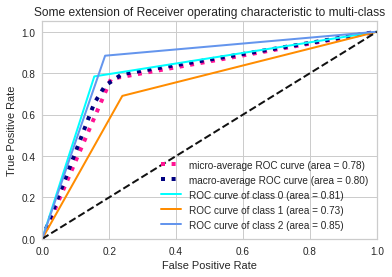

In [89]:
gnb = GaussianNB()
gnb_classifier = fit_classification(gnb, data_dict,{}, model_name = "Naive Bayes Classifier")

best_model = gnb_classifier['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

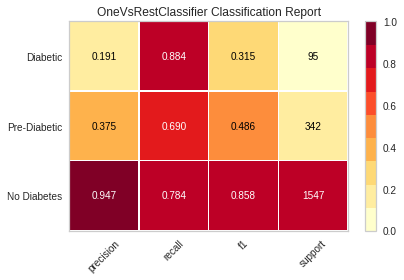

In [90]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  
visualizer.score(X_test, y_test) 
g = visualizer.poof()             

**Ridge Classifier**

  Model: Ridge Classifier
Fit time: 2.19 seconds
Optimal parameters:
{'estimator__alpha': 0.0001}

Were parameters on edge? : True
Score variations around CV search grid : 33.54950576152536
[0.29036162 0.28551691 0.28304688 0.28270464 0.28250091 0.28212564
 0.2811969  0.27722199 0.25744161 0.19294673]


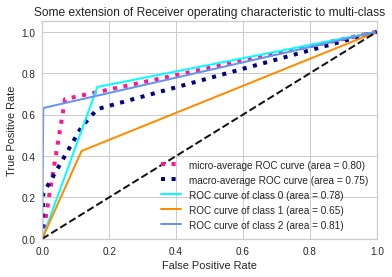

In [91]:
ridge_classifier = RidgeClassifier()
cv_parameters = {"estimator__alpha":np.logspace(-4, 4, num = 10)}

ridge_classifier = fit_classification(ridge_classifier, data_dict, 
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")
best_model = ridge_classifier['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

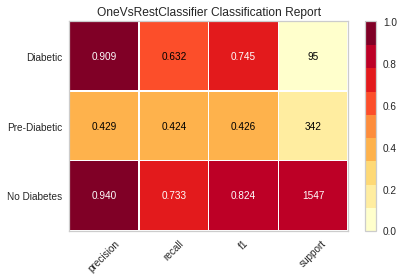

In [92]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()